In [1]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1_W2gFFZmy6ZyC8TPlxB49eDFswdBsQqo',
                                    dest_path='content/face_mask_detection.zip',
                                    unzip=True)

Unzipping...Done.


Loading Libraries

In [2]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.utils import class_weight, shuffle
from tqdm import tqdm_notebook as tqdm
import argparse
import pandas as pd                                     # Data analysis and manipultion tool
import numpy as np                                      # Fundamental package for linear algebra and multidimensional arrays
#Deep Learning Tool
import os                                               # OS module in Python provides a way of using operating system dependent functionality
import cv2                                              # Library for image processing
from sklearn.model_selection import train_test_split    # For splitting the data into train and validation set

Loading and preparing training data

In [3]:
labels = pd.read_csv("/content/content/face_mask_detection/Training_set_face_mask.csv")   # loading the labels
labels.head()           # will display the first five rows in labels dataframe

,filename,label
0,Image_1.jpg,without_mask
1,Image_2.jpg,without_mask
2,Image_3.jpg,without_mask
3,Image_4.jpg,without_mask
4,Image_5.jpg,without_mask


In [4]:
labels.tail()            # will display the last five rows in labels dataframe


,filename,label
11259,Image_11260.jpg,with_mask
11260,Image_11261.jpg,with_mask
11261,Image_11262.jpg,with_mask
11262,Image_11263.jpg,with_mask
11263,Image_11264.jpg,with_mask


Getting images file path

In [5]:
file_paths = [[fname, '/content/content/face_mask_detection/train/' + fname] for fname in labels['filename']]


Confirming if no. of labels is equal to no. of images


In [6]:
# Confirm if number of images is same as number of labels given
if len(labels) == len(file_paths):
    print('Number of labels i.e. ', len(labels), 'matches the number of filenames i.e. ', len(file_paths))
else:
    print('Number of labels does not match the number of filenames')

Number of labels i.e.  11264 matches the number of filenames i.e.  11264


Converting the file_paths to dataframe

In [7]:
images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
images.head()

,filename,filepaths
0,Image_1.jpg,/content/content/face_mask_detection/train/Ima...
1,Image_2.jpg,/content/content/face_mask_detection/train/Ima...
2,Image_3.jpg,/content/content/face_mask_detection/train/Ima...
3,Image_4.jpg,/content/content/face_mask_detection/train/Ima...
4,Image_5.jpg,/content/content/face_mask_detection/train/Ima...


Combining the labels with the images

In [8]:
train_data = pd.merge(images, labels, how = 'inner', on = 'filename')
train_data.head()     

,filename,filepaths,label
0,Image_1.jpg,/content/content/face_mask_detection/train/Ima...,without_mask
1,Image_2.jpg,/content/content/face_mask_detection/train/Ima...,without_mask
2,Image_3.jpg,/content/content/face_mask_detection/train/Ima...,without_mask
3,Image_4.jpg,/content/content/face_mask_detection/train/Ima...,without_mask
4,Image_5.jpg,/content/content/face_mask_detection/train/Ima...,without_mask


Data Pre-processing

In [9]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels_bin = lb.fit_transform(train_data.label) # categorical labels to binary
train_data["labels_bin"] = lb.fit_transform(train_data.label) # categorical labels to binary
labels_OHE =  to_categorical(labels_bin)  # One-Hot-Encoding for the labels binary

In [10]:
train_data.head()     

,filename,filepaths,label,labels_bin
0,Image_1.jpg,/content/content/face_mask_detection/train/Ima...,without_mask,1
1,Image_2.jpg,/content/content/face_mask_detection/train/Ima...,without_mask,1
2,Image_3.jpg,/content/content/face_mask_detection/train/Ima...,without_mask,1
3,Image_4.jpg,/content/content/face_mask_detection/train/Ima...,without_mask,1
4,Image_5.jpg,/content/content/face_mask_detection/train/Ima...,without_mask,1


In [11]:
# Shuffling input and target for optimum training
x = train_data['filepaths']
y = train_data['labels_bin']

x, y = shuffle(x, y, random_state=8)

In [12]:
# Function for Resizing and Reshaping the input images
def centering_image(img):
    
    size = [256,256]
    #shape:(h×w×t)taking the first2 elements(h,w) and unpacking them appropriately 
    img_size = img.shape[:2]
    
    # extracting the excess space for centering.
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    
    #creating centered image by taking a 0-matrix and then re-assigning intensities
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img

    return resized

In [13]:
# Image Resizing and converting them to array


""" 
TQDM is a progress bar library. 
Inserting tqdm (or python -m tqdm)between pipes will pass 
through all stdin to stdout while printing progress to stderr
"""
images = []
with tqdm(total=len(train_data)) as pbar:
    for i, file_path in enumerate(train_data.filepaths.values):
        
        #read image
        img = cv2.imread(file_path,1)
        #color order is changed
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        #resize
        #converting images to square
        if(img.shape[0] > img.shape[1]):
            tile_size = (int(img.shape[1]*256/img.shape[0]),256)
        else:
            tile_size = (256, int(img.shape[0]*256/img.shape[1]))

        #centering the images
        img = centering_image(cv2.resize(img, dsize=tile_size))

        #out put 224*224px 
        img = img[16:240, 16:240]
        images.append(img)
        pbar.update(1)

images = np.array(images)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


In [14]:
# Re-Shuffling processed train data and converting to array
data_num = len(y)
random_index = np.random.permutation(data_num)

x_shuffle = []
y_shuffle = []
for i in range(data_num):
    x_shuffle.append(images[random_index[i]])
    y_shuffle.append(y[random_index[i]])
    
x = np.array(x_shuffle) 
y = np.array(y_shuffle)

In [15]:
### Train val split, OneHotVectorizing categories, Input normalization
###################################################################

#Train val split
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
val_split_num = int(round(0.2*len(y)))

x_train = x[val_split_num:]
y_train = y[val_split_num:]

x_validation = x[:val_split_num]
y_validation = y[:val_split_num]

print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('########################')
print('x_test', x_validation.shape)
print('y_test', y_validation.shape)

# OneHotVectorizing categories
y_train = to_categorical(y_train)
y_validation = to_categorical(y_validation)

# Input normalization
x_train = x_train.astype('float32')
x_validation = x_validation.astype('float32')

x_train /= 255
x_validation /= 255

print('x_train Shape:', x_train.shape, '\t x_test Shape:',x_validation.shape)
print('y_train Shape: ', y_train.shape, '\t y_test Shape:',y_validation.shape)
print('image Shape:', x_train[0].shape)

x_train (9011, 224, 224, 3)
y_train (9011,)
########################
x_test (2253, 224, 224, 3)
y_test (2253,)
x_train Shape: (9011, 224, 224, 3) 	 x_test Shape: (2253, 224, 224, 3)
y_train Shape:  (9011, 2) 	 y_test Shape: (2253, 2)
image Shape: (224, 224, 3)


In [16]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

Building the Model using MobileNetV2

In [17]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 5 #  Take much time and ressource more than GPU goes up to TPU......
BS = 32

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)


model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# Summary of our model
model.summary()

9412608/9406464 [==============================] - 0s 0us/step
[INFO] compiling model...
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                     

In [18]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(x_train, y_train, batch_size=BS),
	steps_per_epoch=len(x_train) // BS,

	validation_data=(x_validation, y_validation),
	validation_steps=len(x_validation) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/5
281/281 [==============================] - 1854s 7s/step - loss: 0.0793 - accuracy: 0.9681 - val_loss: 0.3326 - val_accuracy: 0.9396
Epoch 2/5
281/281 [==============================] - 1811s 6s/step - loss: 0.0187 - accuracy: 0.9932
Epoch 3/5
281/281 [==============================] - 1836s 7s/step - loss: 0.0156 - accuracy: 0.9953
Epoch 4/5
281/281 [==============================] - 1858s 7s/step - loss: 0.0068 - accuracy: 0.9978
Epoch 5/5
281/281 [==============================] - 1849s 7s/step - loss: 0.0062 - accuracy: 0.9984


In [21]:
H.history

{'accuracy': [0.968147873878479,
  0.9932063817977905,
  0.9953224062919617,
  0.9977725744247437,
  0.9984408020973206],
 'loss': [0.07934011518955231,
  0.01866563968360424,
  0.015558180399239063,
  0.006794060580432415,
  0.00622707000002265],
 'val_accuracy': [0.9396360516548157],
 'val_loss': [0.3326035141944885]}

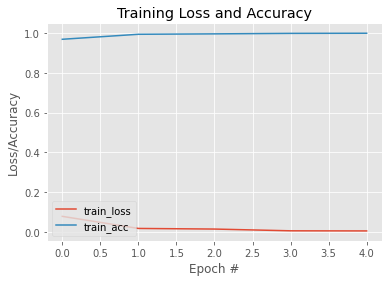

In [23]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
#plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
#plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig(args["plot"])

In [24]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(x_validation, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(y_validation.argmax(axis=1), predIdxs,
	target_names=lb.classes_))


[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       1.00      0.96      0.98      1178
without_mask       0.96      1.00      0.98      1075

    accuracy                           0.98      2253
   macro avg       0.98      0.98      0.98      2253
weighted avg       0.98      0.98      0.98      2253



In [26]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
# saving the model
save_dir = "/content/drive/My Drive/dphi_bootcamp/"
model_name = 'model_MobileNetV2_transferLearning_TPU1_5epochs.h5'
model_path = save_dir + model_name
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/drive/My Drive/dphi_bootcamp/model_MobileNetV2_transferLearning_TPU1_5epochs.h5 
